# Import Python Libraries

In [1]:
# import needed libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import csv
import os
import math

In [2]:
from utility import *
import keras
from keras.models import Sequential 
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

Using TensorFlow backend.


# Load Data Set

In [3]:
#load data in form of np array
data = np.load('images_part1.npy')
data = np.vstack((data, np.load('images_part2.npy')))
data = np.vstack((data, np.load('images_part3.npy')))
data = np.vstack((data, np.load('images_part4.npy')))
                 
label = np.load("labels_part1.npy")
label = np.vstack((label, np.load("labels_part2.npy")))
label = np.vstack((label, np.load("labels_part3.npy")))
label = np.vstack((label, np.load("labels_part4.npy")))

In [4]:
num_of_class = int(np.max(label))
print("# class:", num_of_class)

dim = int(math.sqrt(data.shape[1] / 3 )) # dimension of the image
print("dimension of images:", dim)

# class: 5
dimension of images: 100


In [5]:
data = data.reshape((len(data), dim* dim* 3))
data.shape

(9758, 30000)

In [6]:
classes = {1: 'nv', 2: 'mel', 3: 'bkl', 4: 'bcc', 5: 'akiec'}
class_weights={
    0: 1, # nv
    1: 6.0, # mel
    2: 6.0, # bkl
    3: 10.0, # bcc # Try to make the model more sensitive to Melanoma.
    4: 15.0, # akiec
}

## train test separation

In [7]:
data_train, label_train, data_test, label_test = train_test_shuffled_separation(data, label, train_percent= 0.8)

shuffled data shape: (9758, 30000) shuffled label shape: (9758,)
# train: 7806
# test:  1952
# total: 9758


## convert label (1/2) to one hot code

In [8]:
label_train_one_hot = label_to_one_hot(label_train)
label_test_one_hot = label_to_one_hot(label_test)

## reshape image arrays to N x size x size x 3

In [9]:
data_train = data_train.reshape((data_train.shape[0], dim, dim, 3))
data_test = data_test.reshape((data_test.shape[0], dim, dim, 3))

## normalize image arrays to 0 - 1 

In [10]:
data_train = normalize_data(data_train)
data_test = normalize_data(data_test)
print("image size:", data_train.shape[1:])

image size: (100, 100, 3)


# Display images from dataset

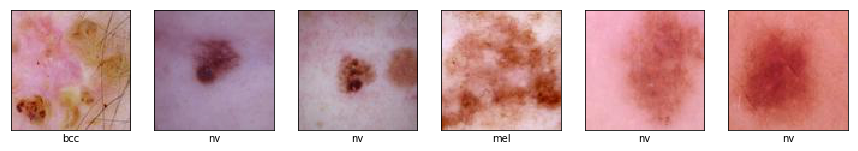

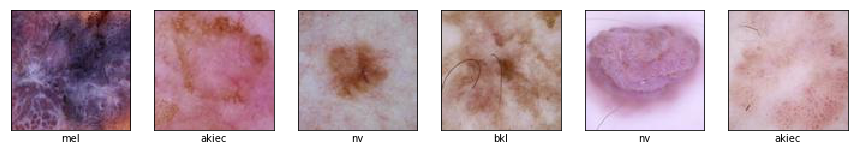

In [11]:
# plot the sample images
list_images(data_train, label_train, classes=classes)
list_images(data_test, label_test, classes=classes)

# VGG-13 implemented in keras

In [12]:
VGG13_model = Sequential()

#  input dimension is (dim, dim, 3)
#  block 1: 2x Conv + Maxpool
# 3 -> 32 feature maps
VGG13_model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(dim, dim, 3), name='block1_conv1'))
VGG13_model.add(Conv2D(32, (3,3), activation='relu', padding='same', name='block1_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block1_pool'))

# block 2: 2x Conv + Maxpool
# 32 -> 64 feature maps
VGG13_model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv1'))
VGG13_model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block2_pool'))

# block 3: 2x Conv + Maxpool
# 64 -> 128 feature maps
VGG13_model.add(Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv1'))
VGG13_model.add(Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block3_pool'))

# block 4: 2x Conv + Maxpool
# 128 -> 256 feature maps
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block4_conv1'))
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block4_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block4_pool'))

# block 5: 2x Conv + Maxpool
# 256 -> 256 feature maps
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block5_conv1'))
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block5_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block5_pool'))

# block 6: 3x FC
VGG13_model.add(Flatten(name='block6_flatten'))
VGG13_model.add(Dense(2048, activation='relu', name='block6_fc1'))
VGG13_model.add(Dropout(0.5)) # dropout = 0.5
VGG13_model.add(Dense(2048, activation='relu', name='block6_fc2'))
VGG13_model.add(Dropout(0.5)) # dropout = 0.5
VGG13_model.add(Dense(num_of_class, activation='softmax', name='predictions')) # output 5 classes

### compile the VGG-13 architecture

#### define top-2 and top-3 accuracy

In [13]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [14]:
# optimizer
# Adam
# AdaDelta
# SGD
SGD = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
VGG13_model.compile(optimizer='AdaDelta', loss='categorical_crossentropy', metrics=['accuracy', top_2_accuracy])

### start training VGG-13

for i in range(len(VGG13_model.layers)):
               print(VGG13_model.layers[i].output)

In [15]:
history = VGG13_model.fit(data_train, label_train_one_hot, batch_size=32, epochs=30, validation_split=0.2,
                         verbose=1, shuffle=True)#, class_weight=class_weights)

Train on 6244 samples, validate on 1562 samples
Epoch 1/30
6244/6244 [==============================] - 25s 4ms/step - loss: 1.0705 - acc: 0.6867 - top_2_accuracy: 0.8073 - val_loss: 0.9987 - val_acc: 0.6997 - val_top_2_accuracy: 0.8054
Epoch 2/30
6244/6244 [==============================] - 16s 3ms/step - loss: 0.9343 - acc: 0.6883 - top_2_accuracy: 0.8237 - val_loss: 0.8529 - val_acc: 0.6997 - val_top_2_accuracy: 0.8560
Epoch 3/30
6244/6244 [==============================] - 16s 3ms/step - loss: 0.8626 - acc: 0.6874 - top_2_accuracy: 0.8422 - val_loss: 0.9439 - val_acc: 0.6997 - val_top_2_accuracy: 0.8464
Epoch 4/30
6244/6244 [==============================] - 16s 3ms/step - loss: 0.8339 - acc: 0.6967 - top_2_accuracy: 0.8411 - val_loss: 1.0399 - val_acc: 0.6184 - val_top_2_accuracy: 0.7196
Epoch 5/30
6244/6244 [==============================] - 17s 3ms/step - loss: 0.8097 - acc: 0.7016 - top_2_accuracy: 0.8453 - val_loss: 0.8300 - val_acc: 0.6997 - val_top_2_accuracy: 0.8489
Epoch 6

### evaluate trained VGG-13 model

In [16]:
score, acc, top2 = VGG13_model.evaluate(data_test, label_test_one_hot, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)
print('Top-2 accuracy:', top2)

1952/1952 [==============================] - 2s 873us/step
Test score: 2.5359976721591635
Test accuracy: 0.6716188524590164
Top-2 accuracy: 0.8263319672131147


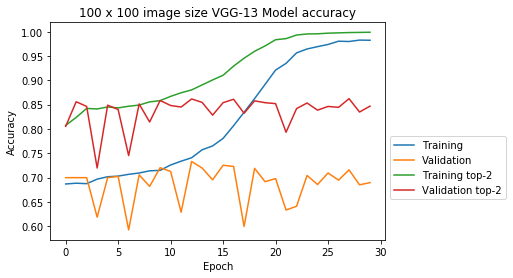

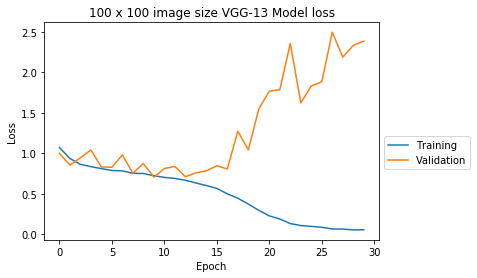

In [17]:
plot_history(history, "100 x 100 image size VGG-13 ")

## save VGG model and parameters

In [26]:
# save VGG13 model to JSON file 
VGG13_model_json = VGG13_model.to_json()
with open("vgg13_model.json", 'w') as json_file:
    json_file.write(VGG13_model_json)

# save VGG13 model parameters to HDF5
VGG13_model.save_weights("vgg13_model.h5")

# LeNet-5 implemented in keras

![LeNet-5](https://cdn-images-1.medium.com/max/1500/1*1TI1aGBZ4dybR6__DI9dzA.png)

In [19]:
LeNet5_model = Sequential()

#  input dimension is (dim, dim, 3)
#  block 1: Conv + Maxpool
# 3 -> 6 feature maps
LeNet5_model.add(Conv2D(6, (3,3), activation='relu', padding='valid', input_shape=(dim, dim, 3), name='block1_conv1'))
LeNet5_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block1_pool'))

# block 2: Conv + Maxpool
# 6 -> 16 feature maps
LeNet5_model.add(Conv2D(16, (3,3), activation='relu', padding='same', name='block2_conv1'))
LeNet5_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block2_pool'))

# block 3: 3x FC
LeNet5_model.add(Flatten(name='block6_flatten'))
LeNet5_model.add(Dense(120, activation='relu', name='block3_fc1'))
LeNet5_model.add(Dense(84, activation='relu', name='block3_fc2'))
LeNet5_model.add(Dense(num_of_class, activation='softmax', name='predictions')) # output two classes

### compile LeNet-5 architecture

In [20]:
# optimizer
# Adam
# AdaDelta
# SGD
LeNet5_model.compile(optimizer='AdaDelta', loss='categorical_crossentropy', metrics=['accuracy', top_2_accuracy])

In [21]:
for i in range(len(LeNet5_model.layers)):
               print(LeNet5_model.layers[i].output)

Tensor("block1_conv1_1/Relu:0", shape=(?, 98, 98, 6), dtype=float32)
Tensor("block1_pool_1/MaxPool:0", shape=(?, 49, 49, 6), dtype=float32)
Tensor("block2_conv1_1/Relu:0", shape=(?, 49, 49, 16), dtype=float32)
Tensor("block2_pool_1/MaxPool:0", shape=(?, 24, 24, 16), dtype=float32)
Tensor("block6_flatten_1/Reshape:0", shape=(?, ?), dtype=float32)
Tensor("block3_fc1/Relu:0", shape=(?, 120), dtype=float32)
Tensor("block3_fc2/Relu:0", shape=(?, 84), dtype=float32)
Tensor("predictions_1/Softmax:0", shape=(?, 5), dtype=float32)


### start training LeNet-5

In [22]:
history = LeNet5_model.fit(data_train, label_train_one_hot, batch_size=32, epochs=30, validation_split=0.2)#validation_data=(data_valid, label_valid)

Train on 6244 samples, validate on 1562 samples
Epoch 1/30
6244/6244 [==============================] - 6s 893us/step - loss: 0.9136 - acc: 0.6887 - top_2_accuracy: 0.8302 - val_loss: 0.8617 - val_acc: 0.7081 - val_top_2_accuracy: 0.8431
Epoch 2/30
6244/6244 [==============================] - 5s 769us/step - loss: 0.8288 - acc: 0.6955 - top_2_accuracy: 0.8435 - val_loss: 0.7608 - val_acc: 0.7055 - val_top_2_accuracy: 0.8579
Epoch 3/30
6244/6244 [==============================] - 5s 764us/step - loss: 0.7936 - acc: 0.7055 - top_2_accuracy: 0.8547 - val_loss: 0.8956 - val_acc: 0.6869 - val_top_2_accuracy: 0.8099
Epoch 4/30
6244/6244 [==============================] - 5s 743us/step - loss: 0.7607 - acc: 0.7135 - top_2_accuracy: 0.8616 - val_loss: 0.7881 - val_acc: 0.7279 - val_top_2_accuracy: 0.8572
Epoch 5/30
6244/6244 [==============================] - 5s 752us/step - loss: 0.7362 - acc: 0.7180 - top_2_accuracy: 0.8674 - val_loss: 0.7570 - val_acc: 0.7132 - val_top_2_accuracy: 0.8598
Ep

### evaluate trained LeNet-5 model

In [23]:
score, acc, top2 = LeNet5_model.evaluate(data_test, label_test_one_hot, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)
print('Top-2 accuracy:', top2)

1952/1952 [==============================] - 1s 439us/step
Test score: 1.4826754429301277
Test accuracy: 0.7264344262295082
Top-2 accuracy: 0.882172131147541


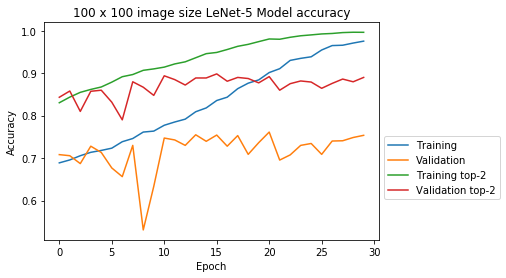

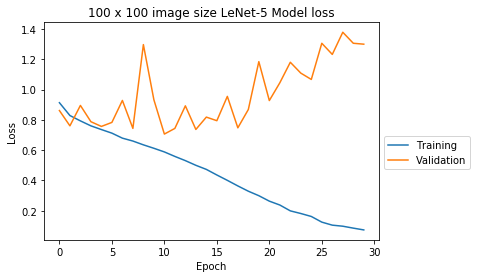

In [24]:
plot_history(history, "100 x 100 image size LeNet-5 ")